<div dir=ltr align=center>
<font color=0F5298 size=7>
    Massive Data Analysis <br>
<font color=000000 size=5>
    Electrical Engineering Department <br>
    Fall 2024 <br>
    Arman Yazdani 400102255 <br>
<font color=696080 size=5>
    Homework 2 - Spark Exercise <br>
<font color=696880 size=4>
    Hossein Sharifi
    
____

# Part 0: Initialization

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

## Dataset Link
[Arxiv Dataset download link](https://drive.google.com/file/d/1-EhpZaY5gvbgNuEU5IskmlQ0EnNAG5cu/view?usp=drive_link).

## Personal Data

In [1]:
student_number = '400102255'
Name = 'Arman'
Last_Name = 'Yazdani'

## Install Pypark & Initialization

In [2]:
# !pip install pyspark
# !pip install pyspark findspark

In [3]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession as ss
spark = ss.builder.appName("MDA2024-HW2").master("local[*]").config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "2g").getOrCreate()
sc=spark.sparkContext
sc

<SparkContext master=local[*] appName=MDA2024-HW2>

# Part 1: Pratical

## Preprocessing

### part 1: parse the json string

In [4]:
import json
arxiv_rdd = sc.textFile("MDA2024-Arxiv-Dataset.json")
parsed_rdd = sc.parallelize(arxiv_rdd.take(5000)).map(lambda line: json.loads(line))
parsed_rdd.take(1)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

### part 2: create a function that extracts and lists all fields (e.g., title, abstract, etc.) from the parsed RDD.

In [5]:
def FieldExtractor(paper): # Also handles None values
  return {
      'id': paper.get('id') if paper.get('id') is not None else 'N/A',
      'submitter' : paper.get('submitter') if paper.get('submitter') is not None else 'N/A',
      'authors' : paper.get('authors') if paper.get('authors') is not None else 'N/A',
      'title' : paper.get('title') if paper.get('title') is not None else 'N/A',
      'comments' : paper.get('comments') if paper.get('comments') is not None else 'N/A',
      'journal-ref' : paper.get('journal-ref') if paper.get('journal-ref') is not None else 'N/A',
      'doi' : paper.get('doi') if paper.get('doi') is not None else 'N/A',
      'report-no' : paper.get('report-no') if paper.get('report-no') is not None else 'N/A',
      'categories' : paper.get('categories'),
      'license' : paper.get('license') if paper.get('license') is not None else 'N/A',
      'abstract' : paper.get('abstract') if paper.get('abstract') is not None else 'N/A',
      'versions' : paper.get('versions') if paper.get('versions') is not None else 'N/A',
      'update_date' : paper.get('update_date') if paper.get('update_date') is not None else 'N/A',
      'authors_parsed' : paper.get('authors_parsed') if paper.get('authors_parsed') is not None else 'N/A'
  }
# Extract and Convert to a list --> Assuming all keys are the same,
# otherwise we can perform reduction
keys = list(parsed_rdd.first().keys())
print("Fieleds: \n", keys)
# Employing function
fields_rdd = parsed_rdd.map(FieldExtractor)
fields_rdd.take(5)

Fieleds: 
 ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'N/A',
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with 

### part 3: Identify and remove or impute any null values, especially in critical fields


- Already taken care of in previous section-part2: <br>(**FieldExtractor Function**)

### part 4: find and remove stopwords

In [6]:
import re
from pyspark.ml.feature import StopWordsRemover
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))
def process_stopwords(item):
    for stopword in stopwords:
      # ! only abstract and title fields have stopwords
      # item['title'] = re.sub(fr' {stopword}$', ' ', item['title'], flags=re.IGNORECASE)
      # item['title'] = re.sub(f' {stopword} ', ' ', item['title'], flags=re.IGNORECASE)
      item['abstract'] = re.sub(f' {stopword} ', ' ', item['abstract'], flags=re.IGNORECASE)
      item['abstract'] = re.sub(fr' {stopword}$', ' ', item['abstract'], flags=re.IGNORECASE)
      # item['authors'] = re.sub(f' {stopword} ', ',', item['authors'], flags=re.IGNORECASE)
    return item

fields_NoStopWords_rdd = fields_rdd.map(process_stopwords)
fields_NoStopWords_rdd.take(10)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'N/A',
  'abstract': '  fully differential calculation perturbative quantum chromodynamics is\npresented production massive photon pairs hadron colliders. All\nnext-to-leading order perturbative contributions quark-antiquark,\ngluon-(anti)quark, gluon-gluon subprocesses included, well as\nall-orders resummation initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. region phase space is\nspecified calculation reliable. Good agreement is\ndemonstrated data Fermilab Tevatron, predictions made for\nmore detailed tests CDF d

### part 5: find and remove useless characters

In [7]:
from itertools import chain
def cleaner(page):
    replacements = {i: ' ' for i in chain(range(33, 64), range(123, 128), range(0, 32), range(91, 97))}
    replacements.update({ord('\n'): ' ',  ord('\u200c'): ' ', ord('\u200e'): ' ',
        ord('\u200d'): ' ', ord('–'): ' ', ord('_'): ' ', ord('،'): ' ', ord('.'): ' ',
        ord('•'): ' ',
    })
    # page['title'] = re.sub(' {2,}', ' ', page['title'].translate(replacements)).strip()
    page['abstract'] = re.sub(' {2,}', ' ', page['abstract'].translate(replacements)).strip()
    return page
clean_rdd0 = fields_NoStopWords_rdd.map(cleaner)
print('abstract without redundant chars')
print(clean_rdd0.take(4))
print('abstract with redundant chars')
print(fields_NoStopWords_rdd.take(4))

abstract without redundant chars
[{'id': '0704.0001', 'submitter': 'Pavel Nadolsky', 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan", 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies', 'comments': '37 pages, 15 figures; published version', 'journal-ref': 'Phys.Rev.D76:013009,2007', 'doi': '10.1103/PhysRevD.76.013009', 'report-no': 'ANL-HEP-PR-07-12', 'categories': 'hep-ph', 'license': 'N/A', 'abstract': 'fully differential calculation perturbative quantum chromodynamics is presented production massive photon pairs hadron colliders All next to leading order perturbative contributions quark antiquark gluon anti quark gluon gluon subprocesses included well as all orders resummation initial state gluon radiation valid at next to next to leading logarithmic accuracy region phase space is specified calculation reliable Good agreement is demonstrated data Fermilab Tevatron predictions made for more detailed tests CDF data P

### Part 6: Even more purity! + Sampling
Since after removing extra charachters, stopwords apear again,we need to remove the new stopwords

In [8]:
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))
def process_stopwords(item):
    for stopword in stopwords:
      # ! only abstract and title fields have stopwords
      # item['title'] = re.sub(fr' {stopword}$', ' ', item['title'], flags=re.IGNORECASE)
      # item['title'] = re.sub(f' {stopword} ', ' ', item['title'], flags=re.IGNORECASE)
      item['abstract'] = re.sub(f' {stopword} ', ' ', item['abstract'], flags=re.IGNORECASE)
      item['abstract'] = re.sub(fr' {stopword}$', ' ', item['abstract'], flags=re.IGNORECASE)
    return item

clean_rdd = clean_rdd0.map(process_stopwords)
clean_rdd.take(10)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'N/A',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders next leading order perturbative contributions quark antiquark gluon anti quark gluon gluon subprocesses included well orders resummation initial state gluon radiation valid next next leading logarithmic accuracy region phase space specified calculation reliable Good agreement demonstrated data Fermilab Tevatron predictions made detailed tests CDF data Predictions shown distributions diphoton pairs produced

## Question 1: A-priori & PCY

### A-priori

#### Description

**A-Priori Algorithm for Finding Frequent Triplets**

We tried to excute the task in 3 stages(5000 samples):  
- **Single Items**
   - Collecting:$\newline$
      Extract individual items (words) from the dataset and count their occurrences.
   - Filtering:$\newline$
   Filter out items that do not meet the minimum support threshold(`500`) and discard irrelevant or low-quality items (e.g., single letters).
   - Result: `66 frequent items out of 20358 unique candidates`

- **Item Pairs**
   - Collecting:
      - Use the frequent single items to generate all possible pairs of items.
      - Count the frequency of each pair in the dataset.
   - Filtering:$\newline$
   Retain only those pairs whose frequency exceeds the minimum support threshold(`400`) and have distinguished elements.
   - Result: `90 frequent items out of 2209 unique candidates`

- **Item Triplets**
   - Collecting:$\newline$
      Combine the frequent pairs to generate candidate triplets.
   - Filtering:$\newline$
   Filter the triplets by the minimum support threshold(`300`) to obtain the final frequent triplets which have distinguished elements.
   - Result: `90 frequent items out of 9565 unique candidates`
   
> The algorithm leverages the **downward closure property**: if an itemset is frequent, all its subsets must also be frequent.$\newline$
> It progressively narrows the search space by focusing only on frequent itemsets at each stage.$\newline$
> Efficiency is improved by avoiding the generation and evaluation of irrelevant or infrequent itemsets.


#### Single Items

##### Collecting

In [9]:
abstract_rdd = clean_rdd.map(lambda record: record.get('abstract', '').lower())

words_rdd = abstract_rdd.flatMap(lambda abstract: abstract.split())

# Map each word to a (word, 1) pair
word_pairs_rdd = words_rdd.map(lambda word: (word, 1))

single_word_counts_rdd = word_pairs_rdd.reduceByKey(lambda x, y: x + y)

single_word_counts = single_word_counts_rdd.collect()
for word, count in single_word_counts:
    print(f"{word}: {count}")

subprocesses: 2
well: 662
space: 767
good: 208
tevatron: 19
predictions: 136
boson: 89
sensitivity: 111
signal: 176
colors: 49
recent: 312
give: 368
proof: 155
work: 339
field: 1456
model: 1827
society: 6
behavior: 300
primary: 77
cause: 43
angular: 160
show: 1381
automata: 22
involves: 37
paths: 33
paper: 817
using: 1225
grid: 40
spaces: 191
p: 779
strengths: 37
enhancement: 53
three: 561
diagonal: 38
cosmology: 74
appropriate: 81
consider: 368
starts: 13
back: 44
formulation: 77
numerical: 332
robust: 64
impacts: 3
interactions: 231
materials: 74
calculations: 247
metals: 31
d: 1196
observations: 493
serpens: 8
star: 545
extra: 87
possibly: 73
luminosity: 255
assumed: 84
sources: 337
analysis: 583
table: 14
cubes: 10
structures: 216
winkler: 1
arbitrary: 193
ones: 121
computing: 61
hilbert: 88
identify: 83
mathbb: 102
main: 293
traces: 14
fourier: 52
coefficient: 83
congruences: 4
exponents: 32
eisentein: 1
furthermore: 128
chen: 5
spinor: 19
amplitudes: 89
kinematic: 63
hadronic: 41

##### Filtering

In [10]:
min_support = 500 

# Filter 
frequent_items_rdd = single_word_counts_rdd.filter(lambda item: item[1] >= min_support and len(item[0]) > 1)

frequent_items = frequent_items_rdd.collect()
for word, count in sorted(frequent_items, key=lambda x: x[1], reverse=True):
    print(f"{word}: {count}")

print(f"Number of frequent items: {len(frequent_items)}")

model: 1827
two: 1756
field: 1456
results: 1411
show: 1381
also: 1370
energy: 1327
one: 1246
using: 1225
mass: 1133
time: 1085
quantum: 1050
study: 1033
theory: 1018
data: 994
system: 976
present: 960
non: 957
high: 894
new: 851
large: 846
state: 840
order: 830
find: 820
paper: 817
function: 817
density: 811
based: 802
phase: 795
space: 767
spin: 763
first: 732
different: 724
observed: 722
properties: 721
models: 704
magnetic: 703
structure: 698
low: 676
case: 674
dimensional: 666
systems: 663
well: 662
number: 655
type: 642
stars: 639
temperature: 638
method: 635
obtained: 624
emission: 612
used: 610
states: 603
ray: 593
analysis: 583
found: 582
may: 577
three: 561
distribution: 559
finite: 558
star: 545
range: 540
use: 539
group: 527
general: 520
problem: 519
galaxies: 506
Number of frequent items: 66


#### Item pairs

##### Collecting

In [11]:
from itertools import combinations

frequent_single_items = set(item[0] for item in frequent_items)

# Filter
filtered_baskets_rdd = abstract_rdd.map(
    lambda abstract: [word for word in abstract.split() if word in frequent_single_items]
)

# Generate candidate pairs
candidate_pairs_rdd = filtered_baskets_rdd.flatMap(
    lambda filtered_words: [
        tuple(sorted(pair)) for pair in combinations(filtered_words, 2)
    ]
)

# Count frequencies
candidate_pair_counts_rdd = candidate_pairs_rdd.map(lambda pair: (pair, 1))
pair_frequencies_rdd = candidate_pair_counts_rdd.reduceByKey(lambda x, y: x + y)

pair_frequencies = pair_frequencies_rdd.collect()
sorted_pairs = sorted(pair_frequencies, key=lambda x: x[1], reverse=True)

for pair, count in sorted_pairs:
    print(f"{pair}: {count}")

print(f"Number of unique 2-itemsets: {len(sorted_pairs)}")

('model', 'model'): 1331
('mass', 'mass'): 1313
('galaxies', 'galaxies'): 1099
('field', 'magnetic'): 1054
('field', 'field'): 1052
('stars', 'stars'): 1032
('spin', 'spin'): 1004
('quantum', 'quantum'): 993
('energy', 'energy'): 922
('model', 'two'): 889
('one', 'two'): 847
('two', 'two'): 808
('ray', 'ray'): 807
('emission', 'ray'): 787
('mass', 'stars'): 787
('emission', 'emission'): 743
('magnetic', 'magnetic'): 704
('field', 'model'): 691
('model', 'models'): 689
('energy', 'model'): 687
('data', 'model'): 673
('field', 'two'): 668
('field', 'theory'): 665
('model', 'results'): 660
('galaxies', 'star'): 660
('results', 'two'): 644
('also', 'model'): 643
('time', 'time'): 638
('phase', 'phase'): 634
('model', 'one'): 631
('mass', 'model'): 624
('star', 'stars'): 606
('quantum', 'two'): 598
('system', 'two'): 596
('mass', 'star'): 588
('galaxies', 'mass'): 586
('data', 'data'): 583
('also', 'two'): 581
('model', 'show'): 579
('show', 'two'): 576
('model', 'phase'): 575
('low', 'mass

##### Filtering

In [12]:
min_support = 400  

# Filter 
frequent_itemPairs_rdd = pair_frequencies_rdd.filter(lambda item: item[1] >= min_support and item[0][0] != item[0][1])

frequent_itemPairs = frequent_itemPairs_rdd.collect()
for word, count in sorted(frequent_itemPairs, key=lambda x: x[1], reverse=True):
    print(f"{word}: {count}")

print(f"Number of frequent items: {len(frequent_itemPairs)}")

('field', 'magnetic'): 1054
('model', 'two'): 889
('one', 'two'): 847
('emission', 'ray'): 787
('mass', 'stars'): 787
('field', 'model'): 691
('model', 'models'): 689
('energy', 'model'): 687
('data', 'model'): 673
('field', 'two'): 668
('field', 'theory'): 665
('model', 'results'): 660
('galaxies', 'star'): 660
('results', 'two'): 644
('also', 'model'): 643
('model', 'one'): 631
('mass', 'model'): 624
('star', 'stars'): 606
('quantum', 'two'): 598
('system', 'two'): 596
('mass', 'star'): 588
('galaxies', 'mass'): 586
('also', 'two'): 581
('model', 'show'): 579
('show', 'two'): 576
('model', 'phase'): 575
('low', 'mass'): 566
('galaxies', 'type'): 564
('energy', 'two'): 560
('also', 'show'): 557
('also', 'results'): 550
('model', 'using'): 542
('dimensional', 'two'): 541
('state', 'two'): 538
('phase', 'two'): 523
('energy', 'high'): 520
('time', 'two'): 517
('model', 'study'): 508
('two', 'using'): 505
('magnetic', 'spin'): 497
('quantum', 'state'): 496
('model', 'present'): 493
('ene

#### Item triplets

##### Collecting

In [13]:
from itertools import combinations

frequent_items_set = set()
for pair, _ in frequent_itemPairs:
    frequent_items_set.update(pair)

# Filter 
filtered_baskets_rdd = abstract_rdd.map(
    lambda abstract: [
        word for word in abstract.split() if word in frequent_items_set
    ]
)

# Generate candidate triplets
candidate_triplets_rdd = filtered_baskets_rdd.flatMap(
    lambda filtered_words: [
        tuple(sorted(triplet)) for triplet in combinations(filtered_words, 3)
    ]
)

# Count frequencies
candidate_triplet_counts_rdd = candidate_triplets_rdd.map(lambda triplet: (triplet, 1))
triplet_frequencies_rdd = candidate_triplet_counts_rdd.reduceByKey(lambda x, y: x + y)

triplet_frequencies = triplet_frequencies_rdd.collect()
for triplet, count in sorted(triplet_frequencies, key=lambda x: x[1], reverse=True):
    print(f"{triplet}: {count}")

print(f"Number of triplets: {len(triplet_frequencies)}")

('galaxies', 'galaxies', 'star'): 2321
('galaxies', 'galaxies', 'galaxies'): 2294
('galaxies', 'galaxies', 'type'): 2227
('stars', 'stars', 'stars'): 1735
('mass', 'mass', 'mass'): 1557
('mass', 'stars', 'stars'): 1495
('emission', 'ray', 'ray'): 1485
('galaxies', 'galaxies', 'mass'): 1384
('field', 'magnetic', 'magnetic'): 1371
('spin', 'spin', 'spin'): 1295
('galaxies', 'type', 'type'): 1252
('emission', 'emission', 'ray'): 1192
('field', 'field', 'magnetic'): 1175
('ray', 'ray', 'ray'): 1173
('mass', 'mass', 'stars'): 1163
('galaxies', 'star', 'star'): 1158
('quantum', 'quantum', 'quantum'): 1134
('galaxies', 'mass', 'type'): 1118
('galaxies', 'mass', 'mass'): 1100
('model', 'model', 'model'): 1056
('star', 'stars', 'stars'): 1023
('low', 'mass', 'mass'): 994
('high', 'stars', 'stars'): 874
('low', 'mass', 'stars'): 870
('galaxies', 'mass', 'star'): 852
('low', 'stars', 'stars'): 848
('quantum', 'spin', 'spin'): 847
('emission', 'emission', 'emission'): 818
('magnetic', 'stars', 'st

##### Filtering

In [16]:
min_support = 300  

# Filter 
frequent_itemTriplets_rdd = triplet_frequencies_rdd.filter(lambda item: item[1] >= min_support and item[0][0] != item[0][1] and item[0][0] != item[0][2] and item[0][2] != item[0][1])

frequent_itemTriplets = frequent_itemTriplets_rdd.collect()
for word, count in sorted(frequent_itemTriplets, key=lambda x: x[1], reverse=True):
    print(f"{word}: {count}")

print(f"Number of frequent items: {len(frequent_itemTriplets)}")

('galaxies', 'mass', 'type'): 1118
('low', 'mass', 'stars'): 870
('galaxies', 'mass', 'star'): 852
('emission', 'energy', 'ray'): 770
('mass', 'star', 'stars'): 766
('emission', 'galaxies', 'star'): 762
('emission', 'high', 'ray'): 732
('galaxies', 'star', 'type'): 729
('emission', 'observed', 'ray'): 657
('emission', 'model', 'ray'): 656
('high', 'mass', 'stars'): 646
('data', 'emission', 'ray'): 607
('galaxies', 'type', 'using'): 602
('model', 'phase', 'two'): 597
('field', 'magnetic', 'two'): 583
('field', 'quantum', 'theory'): 567
('find', 'galaxies', 'star'): 548
('galaxies', 'low', 'mass'): 543
('field', 'magnetic', 'spin'): 543
('one', 'system', 'two'): 537
('energy', 'high', 'ray'): 531
('field', 'magnetic', 'phase'): 527
('model', 'one', 'two'): 527
('model', 'phase', 'state'): 507
('field', 'magnetic', 'model'): 506
('find', 'galaxies', 'mass'): 495
('mass', 'models', 'stars'): 491
('mass', 'stars', 'type'): 466
('magnetic', 'stars', 'time'): 461
('model', 'models', 'two'): 4

### PCY

#### Description

- **First Pass: Frequent Words and Hash Table Initialization**
    - **Objective**: 
      - Identify frequent individual words and populate a hash table with counts of hashed triplets.
    - **Implementation Details**:
      - Splits abstracts into words and filters out words with one or fewer characters.
      - Counts word occurrences using `reduceByKey`, retaining only those exceeding the `support_threshold_first_pass`.
      - Generates triplets from the words in each abstract, hashes them into buckets using a custom hash function, and updates a hash table with counts for each bucket.

    - **Output**:
      - A set of frequent words (`frequent_word_set`).
      - A hash table (`hash_table`) mapping buckets to their counts.

- **Between Pass: Bitmap Creation**
    - **Objective**: Convert the hash table into a bitmap to indicate the presence of frequent buckets, reducing memory usage.
    - **Implementation Details**:
      - Iterates through the hash table, marking buckets as frequent if their count exceeds `support_threshold_first_pass`.
      - Stores this bitmap as a dictionary (`bitmap`), with keys as bucket indices and values as boolean indicators.

    - **Output**:
      - A memory-efficient bitmap (`bitmap`) representing frequent buckets.

- **Second Pass: Candidate Generation and Frequent Triplet Identification**
    - **Objective**: Filter and count triplets that satisfy both:
      1. All words in the triplet are frequent.
      2. The triplet hashes to a bucket marked as frequent in the bitmap.
    - **Implementation Details**:
      - Generates triplets from abstracts, checks their membership in the frequent word set, and validates their bucket against the bitmap using `is_frequent_bucket`.
      - Aggregates triplet counts using `reduceByKey` and filters those exceeding `support_threshold_second_pass`.

    - **Output**:
      - A list of frequent triplets (`frequent_triplets_PCY`) and their counts:

#### Implementation

In [21]:
import hashlib
from itertools import combinations

# Parameters
support_threshold_first_pass = 100  
support_threshold_second_pass = 300 
hash_table_size = 10**10  # Large hash table 

def hash(triplet, hash_table_size):
    hash_obj = hashlib.sha256(str(triplet).encode())
    return int(hash_obj.hexdigest(), 16) % hash_table_size

# Find frequent words
word_counts = clean_rdd.flatMap(lambda record: record['abstract'].split()) \
                    .filter(lambda word: len(word) > 1)\
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda x, y: x + y)

frequent_words = word_counts.filter(lambda x: x[1] >= support_threshold_first_pass) \
                            .map(lambda x: x[0]) \
                            .collect()
frequent_word_set = set(frequent_words)

# Generate triplets, hash them, and populate the hash table
hash_table =clean_rdd.flatMap(
    lambda record: [
        hash(tuple(sorted(triplet)), hash_table_size)
        for triplet in combinations(record['abstract'].split(), 3)
        if len(set(triplet)) == 3 and set(triplet).issubset(frequent_word_set)
    ]
).map(lambda bucket: (bucket, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .collectAsMap()

# Create bitmap based on hash table counts
bitmap = {bucket: (count >= support_threshold_first_pass) for bucket, count in hash_table.items()}

def is_frequent_bucket(triplet):
    bucket = hash(tuple(sorted(triplet)), hash_table_size)
    return bitmap.get(bucket, False)

# Generate and filter candidate triplets
candidate_triplets =clean_rdd.flatMap(
    lambda record: [
        tuple(sorted(triplet))
        for triplet in combinations(record['abstract'].split(), 3)
        if len(set(triplet)) == 3 and set(triplet).issubset(frequent_word_set) and is_frequent_bucket(triplet)
    ]
).map(lambda triplet: (triplet, 1)) \
    .reduceByKey(lambda x, y: x + y)

# Apply the second pass threshold
frequent_triplets_PCY = candidate_triplets.filter(lambda x: x[1] >= support_threshold_second_pass)

# PCY_results
PCY_results = frequent_triplets_PCY.collect()
for word, count in sorted(PCY_results, key=lambda x: x[1], reverse=True):
    print(f"{word}: {count}")

print(f"Number of frequent triplets: {len(PCY_results)}")


('early', 'galaxies', 'type'): 2131
('formation', 'galaxies', 'star'): 1722
('omega', 'pi', 'rho'): 1580
('eta', 'gamma', 'pi'): 1370
('cluster', 'clusters', 'mass'): 1350
('forming', 'galaxies', 'star'): 1236
('AGN', 'galaxies', 'star'): 1219
('early', 'galaxies', 'mass'): 1157
('galaxies', 'mass', 'type'): 1118
('early', 'mass', 'type'): 1110
('complex', 'nu', 'rho'): 1105
('nu', 'real', 'rho'): 1105
('body', 'three', 'two'): 1065
('galaxies', 'galaxy', 'type'): 1062
('mass', 'stars', 'stellar'): 1032
('bar', 'nu', 'pi'): 1014
('black', 'hole', 'mass'): 980
('body', 'four', 'three'): 974
('body', 'force', 'three'): 964
('galaxies', 'massive', 'star'): 934
('galaxies', 'mass', 'stellar'): 934
('mass', 'planet', 'planets'): 921
('formation', 'galaxies', 'mass'): 906
('main', 'sequence', 'stars'): 873
('energy', 'gamma', 'ray'): 865
('emission', 'gamma', 'ray'): 859
('AGN', 'forming', 'galaxies'): 842
('low', 'mass', 'stars'): 840
('cluster', 'clusters', 'galaxies'): 838
('galaxies', 'm

### Jaccard

#### Decription

- **Causes for Low Jaccard Similarity: `0.135`**

    - **a. Hash Collisions in the First Pass**
        -**Issue**: Hash collisions can group multiple triplets into the same bucket, leading to false positives (non-frequent triplets passing as candidates).  
        - **Effect**: Reduces the precision of frequent triplet identification.

    - **b. Support Thresholds:First pass support threshold**
        - **Issue**: Different Support thresholds for A-priori and PCY.  
        - **Effect**: High thresholds may miss true frequent triplets, while low thresholds may allow excessive false positives, reducing recall and precision.

    - **c. Frequent Word Selection:Second pass Support thresholds**
        - **Issue**: Only frequent words pass the first pass. Words just below the frequency threshold may cause valid triplets to be excluded.  
        - **Effect**: Decreases recall by missing true triplets.

    - **d. Abstract Length and Dataset Characteristics**
        - **Issue**: Short abstracts or limited overlap between abstracts can result in fewer candidate triplets.  
        - **Effect**: Mismatch between PCY and Apriori results due to insufficient overlap.

- **Suggestions for Improvement**

    - **Increase Hash Table Size**
        - **Action**: Increase `hash_table_size` to reduce hash collisions.  
        - **Impact**: Improves precision by reducing false positives in the bitmap.

    - **Fine-Tune Support Thresholds**
        - **Action**: Experiment with lower or higher values for `support_threshold_first_pass` and `support_threshold_second_pass`.  
        - **Impact**: Balances recall and precision for better alignment with Apriori results.

    - **Analyze Frequent Word Selection**
        - **Action**: Compare frequent words identified by PCY with those used in Apriori.  
        - **Impact**: Ensures critical words are not excluded, improving recall.

    - **Verify Hash Function**
        - **Action**: Use a robust hash function or combine multiple hash functions to reduce collisions.  
        - **Impact**: Reduces false positives due to hash collisions.

    - **Debugging and Cross-Validation**
        - **Action**: Cross-validate intermediate outputs (e.g., frequent words, hash buckets) between PCY and Apriori.  
        - **Impact**: Identifies where PCY diverges from expected results.

    - **Hybrid Approaches**
        - **Action**: Use Apriori results to guide frequent word selection or validate PCY buckets.  
        - **Impact**: Combines strengths of both algorithms to improve results.


#### Implementation

In [22]:
# Extract sets from both algorithms
Apriori_triplet_set = set([row[0] for row in frequent_itemTriplets if len(row[0])>1]) 
PCY_triplet_set = set([row[0] for row in PCY_results if len(row[0])>1])  

#Jaccard similarity
intersection = Apriori_triplet_set.intersection(PCY_triplet_set)
union = Apriori_triplet_set.union(PCY_triplet_set)
jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0

print(f"Jaccard Similarity: {jaccard_similarity:.4f}")

Jaccard Similarity: 0.1352


## Question 2: LSH

### Description

<div style="text-align: center;">
  <img src="1.jpg" alt="My Image"  height = "400" style="float:center;"/>
</div>

- **Shingling: Convert a document into a set**
  - Shingling
    - To represent each document as a set of k-shingles, which are sequences of k consecutive tokens.
  - Hashing the Shingles
    - To hash each shingle to a unique integer (or bucket) for efficient comparison.
  - From Sets to Boolean Matrices
    - To encode the relationship between shingles and documents in a 0/1 Boolean matrix.
  
- **Min-Hashing: Min-Hashing: Convert large sets to short signatures, while preserving similarity**
  - Define Random Hash Functions 
    > The hash functions will be of the form:
    > $$h_{ab} = ((a\times x + b)\% p) \% N$$
    > $a,b$ are random integers.<br>
    > $p$ is a prime number larger than the number of rows $N$ in the Boolean matrix.<br>
    > $x$ is the row index.
  - Initialize the Signature Matrix
    >The signature matrix M is initialized with infinity ($\infty$) for all entries. It has dimensions K×D, where:<br>
    > K is the number of hash functions.
    > D is the number of documents.
  - Compute Min-Hash Values
    - For each document (column), iterate through the rows of the Boolean matrix and update the signature matrix.
  - Calculate Jaccard Similarity
    - The similarity between two documents is the fraction of rows in the signature matrix where their values match.
- **Locality-Sensitive Hashing (LSH)**
  - Parameter Selection
    - Given the Jaccard similarity threshold t=0.8:
      - b: Number of bands
      - r: Number of rows per band
      - The relationship between b,r, and t is:
        >$t = (\dfrac{1}{b})^{\frac{1}{r}}$
  - Hashing Each Band
    - For each band, hash the portion of each column into a hash table
    - A band is defined as r rows of the matrix for all columns
  - Candidate Pair Identification
    - Documents that hash to the same bucket in at least one band are considered candidate pairs
    - Verify the similarity of these pairs using Jaccard similarity on the original signatures.

### Shingling 

#### Shingling

In [9]:
def generate_shingles(document, k):
    tokens = document.split()
    return set([" ".join(tokens[i:i + k]) for i in range(len(tokens) - k + 1)])

clean_rdd_shingles = clean_rdd.map(lambda doc: (doc['id'], generate_shingles(doc['abstract'], k=5)))

#### Hashing the Shingles

In [10]:
import hashlib

def hash_shingles(shingle):
    return int(hashlib.md5(shingle.encode('utf-8')).hexdigest(), 16)

hashed_rdd = clean_rdd.map(lambda doc: (doc['id'], [hash_shingles(shingle) for shingle in doc['abstract']]))


#### From Sets to Boolean Matrices

In [11]:
# Get all unique shingles
all_shingles = hashed_rdd.flatMap(lambda doc: doc[1]).distinct().collect()

# Create an index for shingles
shingle_index = {shingle: idx for idx, shingle in enumerate(all_shingles)}

# Encode as a Boolean matrix
boolean_matrix_rdd = hashed_rdd.flatMap(
    lambda doc: [(shingle_index[shingle], doc[0]) for shingle in doc[1]]
).groupByKey().mapValues(set)

# Convert to a sparse representation
boolean_matrix = boolean_matrix_rdd.collectAsMap()

### Minhashing

#### Define Random Hash Functions

In [12]:
import random

def generate_hash_functions(num_hashes, num_rows, prime):
    hash_functions = []
    for _ in range(num_hashes):
        a = random.randint(1, prime - 1)
        b = random.randint(0, prime - 1)
        hash_functions.append(lambda x, a=a, b=b: ((a * x + b) % prime) % num_rows)
    return hash_functions

num_rows = len(all_shingles)  # Number of rows in the Boolean matrix
num_hashes = 100  # Number of hash functions
prime = 2**31 - 1  # A large prime number

hash_functions = generate_hash_functions(num_hashes, num_rows, prime)

#### Initialize the Signature Matrix

In [13]:
from math import inf

num_docs = len(clean_rdd.collect())  # Number of documents
signature_matrix = [[inf] * num_docs for _ in range(num_hashes)]

#### Compute Min-Hash Values

In [14]:
def preprocess_text(text):
    # Convert to lowercase, remove stopwords, and tokenize
    tokens = text.lower().split()
    return [token for token in tokens if token not in stopwords and len(token)>1]

# Use this function before generating shingles
doc_ids = clean_rdd.map(lambda doc: {'id': doc['id'], 'abstract': preprocess_text(doc['abstract'])}).map(lambda doc: doc['id']).distinct().collect()

doc_index = {doc_id: idx for idx, doc_id in enumerate(doc_ids)}

boolean_matrix_rows = (
    hashed_rdd
    .flatMap(lambda doc: [(shingle, doc[0]) for shingle in doc[1]])  # Map shingles to documents
    .groupByKey()  # Group by shingle
    .mapValues(set)  # Create a set of documents for each shingle
    .collectAsMap()  # Convert to a dictionary for easy debugging
)

for row, columns in list(boolean_matrix_rows.items()):
    for hash_idx, hash_func in enumerate(hash_functions):
        hashed_row = hash_func(row)
        for col in columns:  # 'col' is a document ID
            doc_idx = doc_index[col]  # Map document ID to integer index
            signature_matrix[hash_idx][doc_idx] = min(signature_matrix[hash_idx][doc_idx], hashed_row)

#### Calculate Jaccard Similarity

In [15]:
def jaccard_similarity(sig_matrix, doc1, doc2):
    matches = sum(1 for i in range(len(sig_matrix)) if sig_matrix[i][doc1] == sig_matrix[i][doc2])
    return matches / len(sig_matrix) if len(sig_matrix) > 0 else 0

# Example similarity calculation between document 0 and document 1
similarity = jaccard_similarity(signature_matrix, 0, 1)
print(f"Jaccard Similarity: {similarity:.4f}")

Jaccard Similarity: 0.7500


### Locality-Sensitive Hashing (LSH)

#### Implementation

In [ ]:
import random
num_bands = 20
rows_per_band = 5
num_buckets = 500  # Number of buckets in each hash table

# LSH hash tables for each band
hash_tables = [{} for _ in range(num_bands)]
for band in range(num_bands):
    start_row = band * rows_per_band
    end_row = start_row + rows_per_band
    
    for col in range(len(signature_matrix[0])):  # Number of documents (columns)
        # Extract band signature for the current document
        band_signature = tuple(row[col] for row in signature_matrix[start_row:end_row])

        # Hash band signature to a bucket
        hash_value = hash(band_signature) % num_buckets
        if hash_value not in hash_tables[band]:
            hash_tables[band][hash_value] = []
        hash_tables[band][hash_value].append(col)

candidates = set()

for band in range(num_bands):
    for bucket, docs in hash_tables[band].items():
        # Add all pairs from this bucket
        for i in range(len(docs)):
            for j in range(i + 1, len(docs)):
                candidates.add((docs[i], docs[j]))

similar_pairs = []

def compute_jaccard_similarity(doc1, doc2, signature_matrix):
for doc1, doc2 in candidates:
    similarity = compute_jaccard_similarity(doc1, doc2, signature_matrix)
    if similarity >= 0.8:
        similar_pairs.append((doc1, doc2, similarity))

    doc1_signature = [row[doc1] for row in signature_matrix]
    doc2_signature = [row[doc2] for row in signature_matrix]
    return sum(1 for i in range(len(doc1_signature)) if doc1_signature[i] == doc2_signature[i]) / len(doc1_signature)


def get_article_data(doc_id, rdd):
    """
    Retrieve article data (ID and abstract) from the RDD given a document ID.
    
    Args:
        doc_id: The ID of the document to retrieve.
        rdd: The RDD containing article data.
    
    Returns:
        The article dictionary if found, otherwise None.
    """
    matches = rdd.filter(lambda x: x['id'] == doc_id).collect()
    if matches:
        return matches[0]
    else:
        print(f"No article found for doc_id: {doc_id}")
        return None

indexed_rdd = clean_rdd.zipWithIndex()

id_to_doc_map = indexed_rdd.map(lambda x: (x[1], x[0])).collectAsMap()


def get_article_data(doc_index, id_to_doc_map):
    """
    Retrieve article data (ID and abstract) using the document index.

    Args:
        doc_index: Index of the document in the signature matrix.
        id_to_doc_map: Mapping from index to document data.

    Returns:
        The article dictionary if found, otherwise None.
    """
    return id_to_doc_map.get(doc_index, None)

random_doc_indices = random.sample(list(id_to_doc_map.keys()), 3)

for doc_index in random_doc_indices:
    # Retrieve the original article
    original_article = get_article_data(doc_index, id_to_doc_map)

    if original_article:
        print(f"Original Document ID: {original_article['id']}")
        print(f"Abstract: {original_article['abstract'][:200]}...\n")

        # Find similar articles
        similar_articles = [
            (doc2_idx if doc1_idx == doc_index else doc1_idx, similarity) 
            for doc1_idx, doc2_idx, similarity in similar_pairs
            if doc1_idx == doc_index or doc2_idx == doc_index
        ]

        # Sort similar articles by similarity in descending order
        similar_articles = sorted(similar_articles, key=lambda x: x[1], reverse=True)[:5]

        # Print the top 5 similar articles
        if similar_articles:
            print("Top 5 Similar Articles:")
            for similar_doc_index, similarity in similar_articles:
                similar_article = get_article_data(similar_doc_index, id_to_doc_map)
                if similar_article:
                    print(f"- Similar Document ID: {similar_article['id']}")
                    print(f"  Abstract: {similar_article['abstract'][:200]}...")
                    print(f"  Similarity: {similarity:.2f}\n")
        else:
            print("No similar articles found.\n")
        print("------")
    else:
        print(f"Document with index {doc_index} not found.\n")

Original Document ID: 0704.3521
Abstract: proved quantum mechanics momentum energy space time dual vector spaces almost complex manifold position representation minimal uncertainty relations equivalent inner product relations bases microscopi...

Top 5 Similar Articles:
- Similar Document ID: 0704.2057
  Abstract: structures globular clusters GCs reflect dynamical states past histories High resolution imaging allows exploration morphologies clusters galaxies Surface brightness profiles new Hubble Space Telescop...
  Similarity: 0.95

- Similar Document ID: 0704.2377
  Abstract: prove lower bound Seshadri constant epsilon L K surface Pic simeq ZZ L particular obtain epsilon L alpha L alpha integer alpha...
  Similarity: 0.92

- Similar Document ID: 0704.1281
  Abstract: past decade high resolution measurements infrared employing adaptive optics imaging m telescopes allowed determining three dimensional orbits stars within ten light hours compact radio source center M...
  Similarity: 0.

#### Trial and Error

- **Observations**
  - The number of candidate pairs increases as:
    - Number of bands increases.
    - Number of rows per band decreases.
  - Explanation:
    - More bands: More opportunities for documents to hash into the same bucket.
    - Fewer rows per band: Reduces the strictness of the similarity threshold, increasing collisions.

- **Effectiveness**:
  - High Precision (Less Noise):
    - Fewer bands and more rows per band (e.g., first configuration) minimize false positives.
  - High Recall (Capture More Candidates):
    - More bands and fewer rows per band (e.g., third configuration) increase the likelihood of capturing similar pairs but may include false positives.


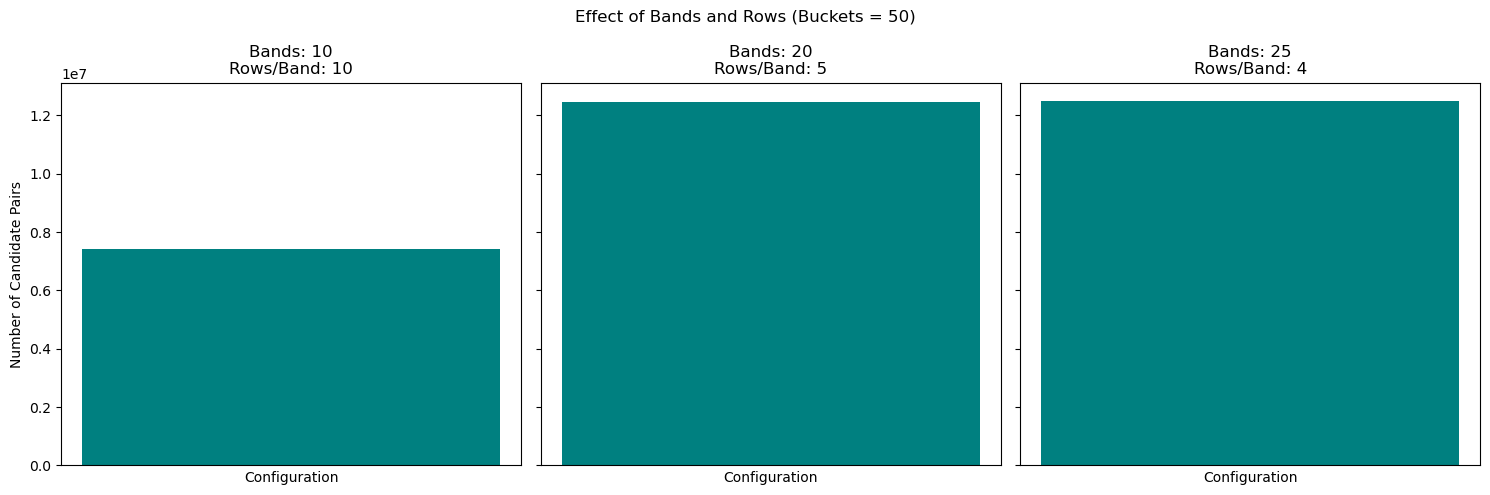

In [47]:
import matplotlib.pyplot as plt

def perform_lsh(signature_matrix, num_bands, rows_per_band, num_buckets):
    """
    Perform LSH to find candidate pairs.

    Args:
        signature_matrix: The Min-Hash signature matrix.
        num_bands: Number of bands.
        rows_per_band: Number of rows per band.
        num_buckets: Number of buckets.

    Returns:
        candidate_pairs: A set of candidate document index pairs.
    """
    hash_tables = [{} for _ in range(num_bands)]
    for band in range(num_bands):
        start_row = band * rows_per_band
        end_row = start_row + rows_per_band
        
        for col in range(len(signature_matrix[0])):  # Number of documents (columns)
            # Extract band signature for the current document
            band_signature = tuple(row[col] for row in signature_matrix[start_row:end_row])

            # Hash band signature to a bucket
            hash_value = hash(band_signature) % num_buckets
            if hash_value not in hash_tables[band]:
                hash_tables[band][hash_value] = []
            hash_tables[band][hash_value].append(col)

    candidates = set()

    for band in range(num_bands):
        for bucket, docs in hash_tables[band].items():
            # Add all pairs from this bucket
            for i in range(len(docs)):
                for j in range(i + 1, len(docs)):
                    candidates.add((docs[i], docs[j]))
    return candidates


results = []

total_rows = 5000  

band_ranges = [10, 20, 25]  
rows_ranges = [10, 5, 4]  
num_buckets = 50
results = []

for num_bands in band_ranges:
    for rows_per_band in rows_ranges:
        if num_bands * rows_per_band * num_buckets== total_rows: 
            
            # Perform LSH with these parameters
            candidate_pairs = perform_lsh(
                signature_matrix,
                num_bands=num_bands,
                rows_per_band=rows_per_band,
                num_buckets=num_buckets,
            )
            
            # Count candidate pairs
            num_candidates = len(candidate_pairs)
            
            # Store results
            results.append((num_bands, rows_per_band, num_buckets, num_candidates))

# Convert results into a heatmap-friendly structure
heatmap_data = {}
for num_bands, rows_per_band, num_buckets, num_candidates in results:
    key = f"bands={num_bands}, rows={rows_per_band}"
    if key not in heatmap_data:
        heatmap_data[key] = []
    heatmap_data[key].append((num_buckets, num_candidates))

fig, axes = plt.subplots(1, len(band_ranges), figsize=(15, 5), sharey=True)

for idx, (num_bands, rows_per_band, num_buckets, num_candidates) in enumerate(results):
    ax = axes[idx]
    
    # Plot a single bar for this configuration
    ax.bar(
        [f"B={num_bands}, R={rows_per_band}"],
        [num_candidates],
        color='teal',
    )
    
    ax.set_title(f"Bands: {num_bands}\nRows/Band: {rows_per_band}")
    ax.set_xlabel("Configuration")
    ax.set_xticks([])
    if idx == 0:
        ax.set_ylabel("Number of Candidate Pairs")

plt.suptitle(f"Effect of Bands and Rows (Buckets = {num_buckets})")
plt.tight_layout()
plt.show()